# Training the model

## Imports

In [4]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchsummary import summary
from torchvision import datasets, transforms, models
import torchvision.models as models
from tqdm.auto import tqdm

from src.globals import TRAIN_DIR, TEST_DIR, BATCH_SIZE, DEVICE


## Data Transformation & Normalization

In [5]:
# Defining augmentation for train data RESIZING ROTATING FLIP CONVERTING TO TENSOR AND NORMALIZATION
train_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform for valid data RESIZE CONVERTING TO TENSOR NORMALIZATION
valid_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform for test data RESIZE CONVERTING TO TENSOR NORMALIZATION
test_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## Loading & Splitting the dataset

In [6]:
# Loading dataset (Train & Test) from directory
dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

# Splitting train dataset into Train and Validation datasets
valid_size = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size])

# Loading datasets into dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total of Samples: {len(dataset) + len(test_dataset)}")
print(
    f"Number of Samples in Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")
print("Classes: ", dataset.classes)


Total of Samples: 800
Number of Samples in Train: 585, Validation: 65, Test: 150
Classes:  ['0% Rotten', '100% Rotten', '25% Rotten', '50% Rotten', '75% Rotten']


## Loading the pretrained VGG16 model

In [8]:
# Loading predefined ResNet34 model 
model = models.vgg16().to(DEVICE)

# Freezing the parameters
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 5)

summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

## Loss function & Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## Validation step

In [11]:
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0

    # change model to work with cuda
    model.to(DEVICE)

    # Iterate over data from validloader
    for ii, (images, labels) in tqdm(enumerate(valid_loader)):

        # Change images and labels to work with cuda
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy


## Training the model

In [12]:
epochs = 3
steps = 0
print_every = 10

# for ploting Graphs
valid_loss_A = []
valid_accuracy_A = []
train_loss_A = []

model.train()
for e in tqdm(range(epochs)):
    print("Starting Epoch", e+1)
    running_loss = 0

    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            # Gradients are turned off as no longer in training
            with torch.inference_mode():
                valid_loss, accuracy = validation(
                    model, valid_loader, criterion)

            ValidLoss = round(valid_loss/len(valid_loader), 3)
            ValidAccuracy = round(float(accuracy/len(valid_loader)), 3)
            TrainingLoss = round(running_loss/print_every, 3)
            print("No. epochs:", (e+1), "\tTraining Loss:", TrainingLoss,
                  "\tValid Loss", ValidLoss, "\tValid Accuracy", ValidAccuracy)

            valid_loss_A.append(ValidLoss)
            valid_accuracy_A.append(ValidAccuracy)
            train_loss_A.append(TrainingLoss)

            if (e+1) == epochs:
                # Saving: feature weights, new model.fc, index-to-class mapping, optimizer state, and No. of epochs
                checkpoint = {
                    'state_dict': model.state_dict(),
                    'model': model.fc,
                    'class_to_idx': dataset.class_to_idx,
                    'opt_state': optimizer.state_dict,
                    'num_epochs': epochs
                }
                #name = str(e)
                path = '../model/modelFinal.pth'
                torch.save(checkpoint, path)

            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)


  0%|          | 0/3 [00:00<?, ?it/s]

Starting Epoch 1


/home/hakim/.local/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
3it [00:16,  5.63s/it]


No. epochs: 1 	Training Loss: 1.657 	Valid Loss 5.099 	Valid Accuracy 0.12


 33%|███▎      | 1/3 [07:15<14:31, 435.84s/it]

Starting Epoch 2


3it [00:13,  4.34s/it]


No. epochs: 2 	Training Loss: 0.204 	Valid Loss 7.446 	Valid Accuracy 0.278


3it [00:14,  4.77s/it]


No. epochs: 2 	Training Loss: 1.754 	Valid Loss 6.606 	Valid Accuracy 0.172


 67%|██████▋   | 2/3 [14:18<07:07, 427.92s/it]

Starting Epoch 3


3it [00:16,  5.36s/it]


No. epochs: 3 	Training Loss: 0.299 	Valid Loss 3.427 	Valid Accuracy 0.262


3it [00:12,  4.31s/it]


No. epochs: 3 	Training Loss: 1.62 	Valid Loss 1.26 	Valid Accuracy 0.503


100%|██████████| 3/3 [20:48<00:00, 416.14s/it]


## Ploting the results

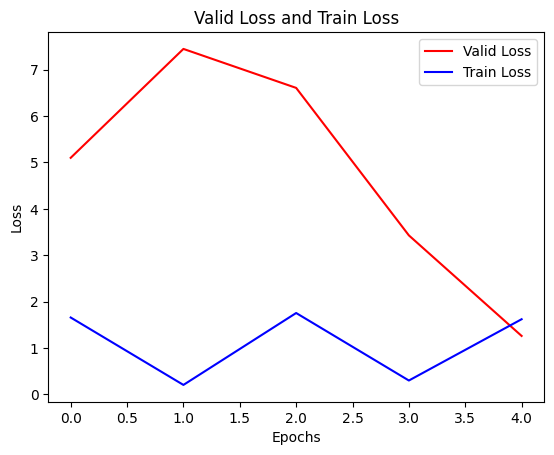

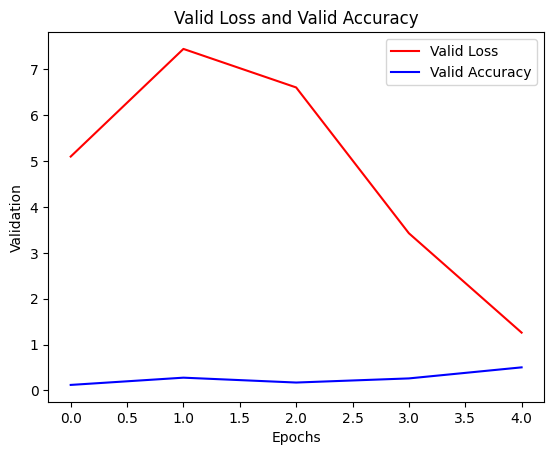

In [13]:
epochs = range(len(valid_accuracy_A))


plt.plot(epochs, valid_loss_A, 'r', label='Valid Loss')
plt.plot(epochs, train_loss_A, 'b', label='Train Loss')
plt.title('Valid Loss and Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, valid_loss_A, 'r', label='Valid Loss')
plt.plot(epochs, valid_accuracy_A, 'b', label='Valid Accuracy')
plt.title('Valid Loss and Valid Accuracy')
plt.ylabel('Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()
